In [2]:
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
COST_FOR_SICK = 10000 # per year
COST_FOR_HEALTHY = 500 # per year
SICKNESS_PREVALENCE = 0.05

In [4]:
def average_cost_correctly_classified_healthy(p, fpr, cost_per_healthy):
    return (1 - p) * (1 - fpr) * cost_per_healthy

def average_cost_misclassified_sick(p, tpr, cost_per_sick):
    return p * (1 - tpr) * cost_per_sick

def total_enrolled(p, fpr, tpr):
    total_sick_enrolled = p * (1 - tpr)
    total_healthy_enrolled = (1 - p) * (1 - fpr)
    return total_sick_enrolled + total_healthy_enrolled

def average_premium_to_break_even(fpr, 
                                  tpr, 
                                  cost_for_sick=COST_FOR_SICK, 
                                  cost_for_healthy=COST_FOR_HEALTHY, 
                                  p=SICKNESS_PREVALENCE):
    cost = average_cost_misclassified_sick(p, tpr, cost_for_sick)
    cost += average_cost_correctly_classified_healthy(p, fpr, cost_for_healthy)
    premium = cost / total_enrolled(p, fpr, tpr) / 12
    if isinstance(fpr, numpy.ndarray):
        premium[(tpr < fpr) | (tpr < 0.2)] = NaN
    return premium

def profit_per_patient(fpr, 
                        tpr, 
                        daily_premium,
                        cost_for_sick=COST_FOR_SICK, 
                        cost_for_healthy=COST_FOR_HEALTHY, 
                        p=SICKNESS_PREVALENCE):
    cost = average_cost_misclassified_sick(p, tpr, cost_for_sick)
#     print 'average cost misclassified sick {:.2f}'.format(cost)
    cost += average_cost_correctly_classified_healthy(p, fpr, cost_for_healthy)
#     print 'plus average cost correctly classified healthy = {:.2f}'.format(cost)
#     print 'total enrolled', total_enrolled(p, fpr, tpr)
    profit_per_person = total_enrolled(p, fpr, tpr) * daily_premium * 365 - cost
    if isinstance(fpr, numpy.ndarray):
        profit_per_person[(tpr < fpr)] = NaN
    return profit_per_person

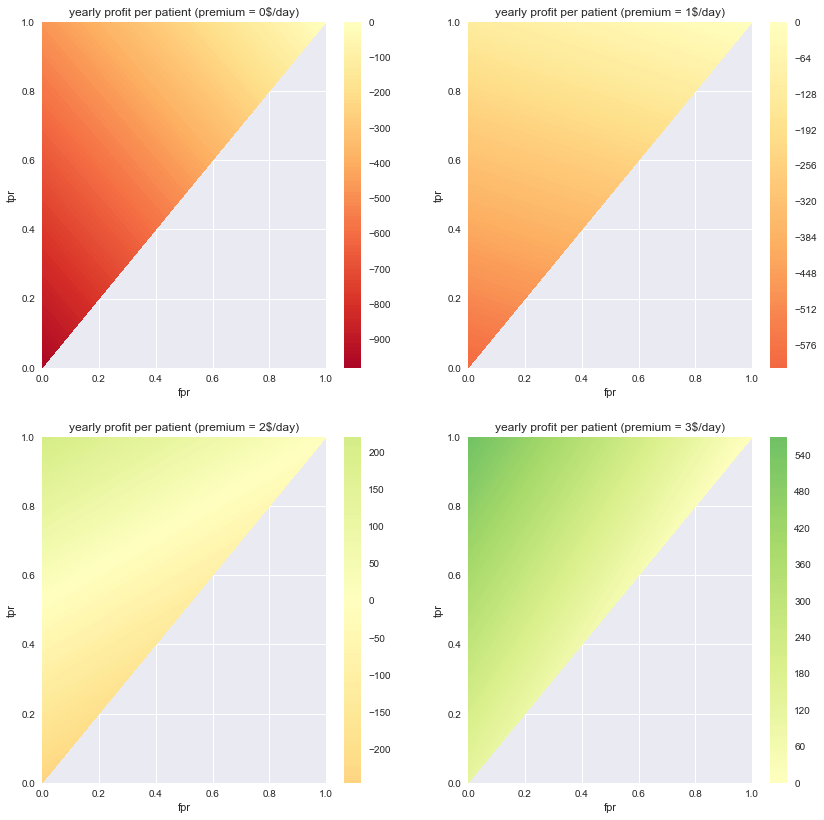

In [5]:
import matplotlib.colors as colors

cm = get_cmap('RdYlGn')
c_norm = colors.Normalize(vmin=-1000, vmax=1000)

figure(figsize=(14, 14))
xvec = linspace(0, 1, 1000)                               
x, y = meshgrid(xvec, xvec)
for premium in range(4):
    ax = subplot(2, 2, premium + 1)
    z = profit_per_patient(x, y, premium)
    contourf(x, y, z, 100, cmap=cm, norm=c_norm) 
    colorbar(norm=c_norm) 

    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title('yearly profit per patient (premium = {}$/day)'.format(premium))

In [6]:
from ipywidgets import interact

In [7]:
def plot_profit(daily_premium, cost_for_sick, cost_for_healthy , prevelance):
    figure(figsize=(7,7))
    xvec = linspace(0, 1, 50)                               
    x, y = meshgrid(xvec, xvec)
    z = profit_per_patient(x, y, daily_premium, cost_for_sick, cost_for_healthy, prevelance)
    contourf(x, y, z, 100, cmap=cm, norm=c_norm) 
    colorbar(norm=c_norm) 

    xlabel('fpr')
    ylabel('tpr')
    title('yearly profit per patient')

<function __main__.plot_profit>

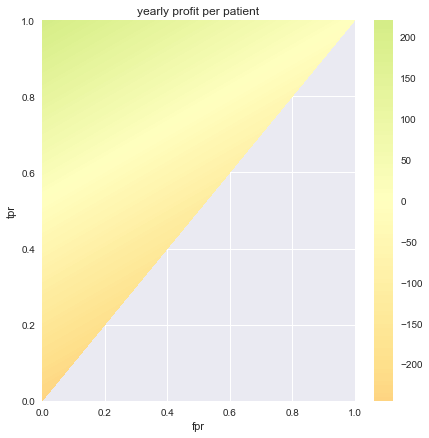

In [8]:
interact(plot_profit, 
         daily_premium=(0, 4, 0.5),
         cost_for_sick=(5000, 20000, 5000),
         cost_for_healthy=(0, 1000, 500),
         prevelance=(0.01, 0.1, 0.01))